In [62]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import scipy
from scipy import signal, stats
from scipy.stats import pointbiserialr
import math
from math import sqrt

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.base import clone

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.pipeline import make_pipeline, Pipeline

import mrmr

In [2]:
def r_nr_asarrays(column_name, full_dataframe):
    responders = np.array(full_dataframe.loc[full_dataframe["response"] == 1, column_name])
    non_responders = np.array(full_dataframe.loc[full_dataframe["response"] == 0, column_name])
    return responders, non_responders

### Load the dataframe

In [3]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('surrogate_18042022.csv', index_col=0) # Read the features dataframe

full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values
full_df.loc[full_df["response"] == "RP", "response"] = 1
full_df.loc[full_df["response"] == "PR", "response"] = 1
full_df.loc[full_df["response"] == "R", "response"]  = 1
full_df.loc[full_df["response"] == "NR", "response"] = 0

full_df.drop(columns=['patient'], inplace=True)
full_df = full_df[full_df.columns.drop(list(full_df.filter(regex='DTF')))] # dropping the DTF columns

In [4]:
train=full_df.sample(n=30, random_state=42)
test=full_df.drop(train.index)
full_df = train.sort_index().copy()
test_df = test.copy()

<AxesSubplot:xlabel='response', ylabel='count'>

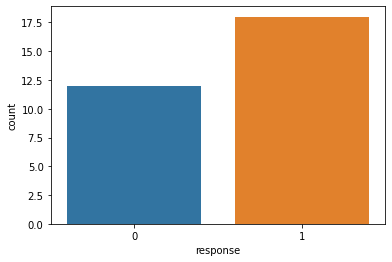

In [5]:
sns.countplot(full_df['response'])

### Features selection

Here we perform the feature selection for the methods. The CFS is executed once and it has a fixed set for all the methods, while the MrMr and the SFS should be executed for all the methods.

CFS:
https://johfischer.com/2021/08/06/correlation-based-feature-selection-in-python-from-scratch/#:~:text=The%20correlation%2Dbased%20feature%20selection%20(CFS)%20method%20is%20a,the%20name%20already%20suggest%3A%20correlations.

Maximum relevance Minimum redundancy (MrMr):
https://github.com/smazzanti/mrmr

https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b

Sequential Feature Selection (SFS):


##### Correlation based feature selection (CFS)

In [6]:
from scipy.stats import pointbiserialr
from math import sqrt

def getMerit(subset, label, df):
    k = len(subset)

    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr( df[label], df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )

    # average feature-feature correlation
    corr = df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        """
        item already in priority queue with smaller priority:
        -> update its priority
        item already in priority queue with higher priority:
        -> do nothing
        if item not in priority queue:
        -> push it
        """
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

In [7]:
label = 'response'

# list with feature names (V1, V2, V3, ...)
features = full_df.columns.tolist()
features.remove(label)

# First we get the initial feature
best_value = -1
best_feature = ''
for feature in features:
    coeff = pointbiserialr(full_df[label], full_df[feature])
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))

# Then we initialize the queue and push the best feature into it
# initialize queue
queue = PriorityQueue()

# push first tuple (subset, merit)
queue.push([best_feature], best_value)

Feature PDC_beta_SLEEP_GE with merit 0.4319


In [8]:
# list for visited nodes
visited = []

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 5


# repeat until queue is empty
# or the maximum number of backtracks is reached
while not queue.isEmpty():
    # get element of queue with highest merit
    subset, priority = queue.pop()
    
    # check whether the priority of this subset
    # is higher than the current best subset
    if (priority < best_value):
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # goal condition
    if (n_backtrack == max_backtrack):
        break
    
    # iterate through all features and look of one can
    # increase the merit
    for feature in features:
        temp_subset = subset + [feature]
        
        # check if this subset has already been evaluated
        for node in visited:
            if (set(node) == set(temp_subset)):
                break
        # if not, ...
        else:
            # ... mark it as visited
            visited.append( temp_subset )
            # ... compute merit
            merit = getMerit(temp_subset, label, full_df)
            # and push it to the queue
            queue.push(temp_subset, merit)

In [9]:
features_subset_cbfs = best_subset.copy()

##### Maximum relevance minimum redundancy (MrMr)

In [11]:
def MrMr_features_number_test(model, X, Y, features_n_end, cv_folds=10):
    """
    Given a ML model this function returns the score of the subsets obtained through the MrMr
    feature selection.
    Input:
        model (sk-learn ML model) : the ML model;
        X (Pandas DataFrame) : Pandas DataFrame containing the features without the labels;
        Y (Pandas Series) : Pandas Series (column) containing the labels for each sample;
        features_n_end (int) : maximum number of features to test;
    Output:
        results (Pandas DataFrame) : Pandas DataFrame containing the subset and the score associated to it.
    """
    feature_names = X.columns
    results = {}
    results['features'], results['features_len'], results['cv_acc'] = [], [], []
    
    selected_features = mrmr.mrmr_classif(X=X, y=Y, K=features_n_end, show_progress=False)
    
    Y_ = Y.to_numpy(dtype='int')
    
    for n_features in tqdm(range(1, features_n_end)):
        subset_features = selected_features[0:n_features]
        
        X_ = X[subset_features].to_numpy()
        
        scores_subset = cross_val_score(model, X_, Y_, cv=cv_folds)
        best_score = np.mean(scores_subset)
        
        results['features'].append(subset_features)
        results['features_len'].append(n_features)
        results['cv_acc'].append(best_score)
    results = pd.DataFrame(results)
    return results.sort_values(by=['cv_acc', 'features_len'], ascending=[False, True], ignore_index=True)

##### Sequential Feature Selection

In [12]:
from sklearn.feature_selection import SequentialFeatureSelector

def SFS_features_number_test(model, X, Y, features_n_end, cv_folds=10):
    """
    Given a ML model this function returns the score of the subsets obtained through the Sequential
    Feature Selection.
    Input:
        model (sk-learn ML model) : the ML model;
        X (Pandas DataFrame) : Pandas DataFrame containing the features without the labels;
        Y (Pandas Series) : Pandas Series (column) containing the labels for each sample;
        features_n_end (int) : maximum number of features to test;
    Output:
        results (Pandas DataFrame) : Pandas DataFrame containing the subset and the score associated to it.
    """
    feature_names = X.columns
    results = {}
    results['features'], results['features_len'], results['cv_acc'] = [], [], []
    sfs_forward = SequentialFeatureSelector(model, n_features_to_select=features_n_end, direction="forward").fit(X, Y)
    selected_features = list(feature_names[sfs_forward.get_support()])
    Y_ = Y.to_numpy(dtype='int')
    for n_features in tqdm(range(1, features_n_end)):
        subset_features = selected_features[0:n_features]
        
        X_ = X[subset_features].to_numpy()
        
        scores_subset = cross_val_score(model, X_, Y_, cv=cv_folds)
        best_score = np.mean(scores_subset)
        
        results['features'].append(subset_features)
        results['features_len'].append(n_features)
        results['cv_acc'].append(best_score)
    results = pd.DataFrame(results)
    return results.sort_values(by=['cv_acc', 'features_len'], ascending=[False, True], ignore_index=True)

### Model selection and tuning

On this stage we select the best model, but first we find the best hyperparameters combination for each set of features selected

In [18]:
best_feature_subset_models = {}

##### SVM Linear kernel

In [13]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = MinMaxScaler()
ml_model = SVC(kernel='linear')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 66.25it/s]


In [15]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6

scaler = MinMaxScaler()
ml_model = SVC(kernel='linear')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__kernel': ['linear'], 'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', SVC(C=10, kernel='linear', tol=0.1))]), with a validation acc of: 0.8999999999999999
The best MRMR (with 7 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', SVC(C=1, kernel='linear', tol=0.1))]), with a validation acc of: 0.7999999999999999
The best SFS (with 8 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', SVC(C=10, kernel='linear', tol=0.1))]), with a validation acc of: 0.6


In [16]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.7142857142857143
The test accuracy obtained for the SFS model is: 0.5714285714285714


In [20]:
best_feature_subset_models['SVM_linear'] = features_mrmr

##### SVM rbf kernel

In [22]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = MinMaxScaler()
ml_model = SVC(kernel='rbf')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 69.65it/s]


In [23]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6


scaler = MinMaxScaler()
ml_model = SVC()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__gamma': [0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'], 'ml_model__kernel': ['rbf'],
  'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', SVC(C=100, gamma=0.1, tol=0.1))]), with a validation acc of: 0.8999999999999999
The best MRMR (with 10 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()), ('ml_model', SVC(C=1, tol=0.1))]), with a validation acc of: 0.8666666666666667
The best SFS (with 11 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', SVC(C=100, gamma=0.1, tol=0.1))]), with a validation acc of: 0.6666666666666666


In [26]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.7142857142857143
The test accuracy obtained for the SFS model is: 0.5714285714285714


In [27]:
best_feature_subset_models['SVM_rbf'] = features_mrmr

##### SVM polynomial kernel

In [28]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = MinMaxScaler()
ml_model = SVC(kernel='poly')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 66.34it/s]


In [29]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6

scaler = MinMaxScaler()
ml_model = SVC(kernel='poly')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__gamma': [0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'], 'ml_model__kernel': ['poly'],
  'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', SVC(C=1000, gamma=0.1, kernel='poly', tol=0.1))]), with a validation acc of: 0.8666666666666666
The best MRMR (with 13 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', SVC(C=1, kernel='poly', tol=0.1))]), with a validation acc of: 0.8666666666666666
The best SFS (with 17 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', SVC(C=1000, gamma=0.1, kernel='poly', tol=0.1))]), with a validation acc of: 0.6333333333333334


In [30]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.7142857142857143
The test accuracy obtained for the MrMr model is: 0.42857142857142855
The test accuracy obtained for the SFS model is: 0.7142857142857143


In [27]:
best_feature_subset_models['SVM_poly'] = features_sfs

##### Gaussian Process

In [32]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = MinMaxScaler()
ml_model = GaussianProcessClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 40.35it/s]


In [33]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

cv_folds = 6

scaler = MinMaxScaler()
ml_model = GaussianProcessClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__kernel': [DotProduct() + WhiteKernel(), DotProduct() + RBF(), RBF() + WhiteKernel(), DotProduct() + WhiteKernel() + RBF(),
             DotProduct()*WhiteKernel(), DotProduct()*RBF(), WhiteKernel()*RBF(), RBF()*DotProduct() + WhiteKernel(),
                       DotProduct()*WhiteKernel() + WhiteKernel()]},]

param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) * RBF(length_scale=1)))]), with a validation acc of: 0.8999999999999999
The best MRMR (with 7 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1)))]), with a validation acc of: 0.8666666666666666
The best SFS (with 1 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) * RBF(length_scale=1)))]), with a validation acc of: 0.5


In [34]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.8571428571428571
The test accuracy obtained for the SFS model is: 0.7142857142857143


In [35]:
best_feature_subset_models['gaussian_process'] = features_mrmr

##### K-Nearest Neighbors

In [36]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = MinMaxScaler()
ml_model = KNeighborsClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 55.09it/s]


In [37]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

cv_folds = 6

scaler = MinMaxScaler()
ml_model = KNeighborsClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__leaf_size': list(range(1,50)), 'ml_model__n_neighbors': list(range(1,30)), 'ml_model__p': [1,2],},
 ]

param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]), with a validation acc of: 0.8666666666666666
The best MRMR (with 5 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1))]), with a validation acc of: 0.8666666666666667
The best SFS (with 11 features) model found is Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]), with a validation acc of: 0.6


In [38]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.5714285714285714
The test accuracy obtained for the SFS model is: 0.5714285714285714


In [39]:
best_feature_subset_models['KNN'] = features_sfs

##### Decision Tree

The decision tree perform the feature selection by itself, so there is no need to use the feature selection criteria.

In [40]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

Y_ = Y.to_numpy(dtype='int')
#X_dt = X.copy()

cv_folds = 6

#scaler = MinMaxScaler()
ml_model = DecisionTreeClassifier(random_state=42)
model = Pipeline(steps=[("ml_model", ml_model)])

max_depth = list(range(30)) + [None]
min_samples_split=[1, 2]
min_samples_leaf=[1, 2]
criterion = ['gini', 'entropy']

param_grid = [
  {'ml_model__max_depth': max_depth, 'ml_model__min_samples_split': min_samples_split, 'ml_model__min_samples_leaf': min_samples_leaf,
  'ml_model__criterion': criterion},
 ]

param_lookup_dt = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_dt.fit(X, Y_)
best_model_dt = param_lookup_dt.best_estimator_

scores_subset_dt = cross_val_score(best_model_dt, X, Y_, cv=cv_folds)
best_score_dt = np.mean(scores_subset_dt)

print(f'The best DT model found is {best_model_dt}, with a validation acc of: {best_score_dt}')

The best DT model found is Pipeline(steps=[('ml_model',
                 DecisionTreeClassifier(max_depth=2, random_state=42))]), with a validation acc of: 0.7666666666666667


In [41]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_dt = X.to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_dt = clone(best_model_dt)

best_model_dt.fit(X_train_dt, Y_train)

Y_pred_dt = best_model_dt.predict(X_test.to_numpy())

dt_test_acc = accuracy_score(Y_test, Y_pred_dt)

print(f'The test accuracy obtained for the DT model is: {dt_test_acc}')

The test accuracy obtained for the DT model is: 0.42857142857142855


##### Random Forest

In [42]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

Y_ = Y.to_numpy(dtype='int')

cv_folds = 6

ml_model = RandomForestClassifier(random_state=42)
model = Pipeline(steps=[("ml_model", ml_model)])

max_depth = list(range(10)) + [None]
min_samples_split=[1, 2]
min_samples_leaf=[1, 2]
criterion = ['gini']
n_estimators = list(range(5, 166, 20))

param_grid = [
  {'ml_model__max_depth': max_depth, 'ml_model__min_samples_split': min_samples_split, 'ml_model__min_samples_leaf': min_samples_leaf,
  'ml_model__criterion': criterion, 'ml_model__n_estimators': n_estimators},
 ]

param_lookup_dt = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_dt.fit(X, Y_)
best_model_dt = param_lookup_dt.best_estimator_

scores_subset_dt = cross_val_score(best_model_dt, X, Y_, cv=cv_folds)
best_score_dt = np.mean(scores_subset_dt)

print(f'The best DT model found is {best_model_dt}, with a validation acc of: {best_score_dt}')

The best DT model found is Pipeline(steps=[('ml_model',
                 RandomForestClassifier(max_depth=2, min_samples_leaf=2,
                                        n_estimators=5, random_state=42))]), with a validation acc of: 0.7666666666666667


In [43]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_dt = X.to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_dt = clone(best_model_dt)

best_model_dt.fit(X_train_dt, Y_train)

Y_pred_dt = best_model_dt.predict(X_test.to_numpy())

dt_test_acc = accuracy_score(Y_test, Y_pred_cbfs)

print(f'The test accuracy obtained for the Random Forest model is: {dt_test_acc}')

The test accuracy obtained for the Random Forest model is: 0.5714285714285714


##### AdaBoost

In [44]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

Y_ = Y.to_numpy(dtype='int')

cv_folds = 6

base_estimator = DecisionTreeClassifier(max_depth=2, random_state=42)
ml_model = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
model = Pipeline(steps=[("ml_model", ml_model)])

learning_rate = list(range(1, 11, 1))
n_estimators = list(range(5, 166, 20))

param_grid = [
  {'ml_model__n_estimators': n_estimators, 'ml_model__learning_rate':learning_rate}
 ]
param_lookup_dt = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_dt.fit(X, Y_)
best_model_dt = param_lookup_dt.best_estimator_

scores_subset_dt = cross_val_score(best_model_dt, X, Y_, cv=cv_folds)
best_score_dt = np.mean(scores_subset_dt)

print(f'The best DT model found is {best_model_dt}, with a validation acc of: {best_score_dt}')

The best DT model found is Pipeline(steps=[('ml_model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                          random_state=42),
                                    learning_rate=2, n_estimators=45,
                                    random_state=42))]), with a validation acc of: 0.8000000000000002


In [45]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_dt = X.to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_dt = clone(best_model_dt)

best_model_dt.fit(X_train_dt, Y_train)

Y_pred_dt = best_model_dt.predict(X_test.to_numpy())

dt_test_acc = accuracy_score(Y_test, Y_pred_cbfs)

print(f'The test accuracy obtained for the AdaBoost model is: {dt_test_acc}')

The test accuracy obtained for the AdaBoost model is: 0.5714285714285714


### Model selection and tuning with another normalization

On this stage we select the best model, but first we find the best hyperparameters combination for each set of features selected

##### SVM Linear kernel

In [46]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = StandardScaler()
ml_model = SVC(kernel='linear')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 62.26it/s]


In [47]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6

scaler = StandardScaler()
ml_model = SVC(kernel='linear')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__kernel': ['linear'], 'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=10, kernel='linear', tol=0.1))]), with a validation acc of: 0.8999999999999999
The best MRMR (with 9 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=10, kernel='linear', tol=0.1))]), with a validation acc of: 0.8666666666666666
The best SFS (with 13 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=10, kernel='linear', tol=0.1))]), with a validation acc of: 0.6666666666666666


In [48]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.2857142857142857
The test accuracy obtained for the MrMr model is: 0.2857142857142857
The test accuracy obtained for the SFS model is: 0.5714285714285714


##### SVM rbf kernel

In [49]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = StandardScaler()
ml_model = SVC(kernel='rbf')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 65.28it/s]


In [50]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6


scaler = StandardScaler()
ml_model = SVC()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__gamma': [0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'], 'ml_model__kernel': ['rbf'],
  'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=1000, gamma=0.001, tol=0.1))]), with a validation acc of: 0.8999999999999999
The best MRMR (with 10 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=100, gamma=0.001, tol=0.1))]), with a validation acc of: 0.8666666666666666
The best SFS (with 10 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=1000, gamma=0.001, tol=0.1))]), with a validation acc of: 0.5


In [51]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.7142857142857143
The test accuracy obtained for the SFS model is: 0.42857142857142855


##### SVM polynomial kernel

In [52]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = StandardScaler()
ml_model = SVC(kernel='poly')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 57.45it/s]


In [53]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6

scaler = StandardScaler()
ml_model = SVC(kernel='poly')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__gamma': [0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'], 'ml_model__kernel': ['poly'],
  'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=100, gamma='auto', kernel='poly', tol=0.1))]), with a validation acc of: 0.7666666666666667
The best MRMR (with 5 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=100, gamma='auto', kernel='poly', tol=0.1))]), with a validation acc of: 0.7999999999999999
The best SFS (with 13 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', SVC(C=100, gamma='auto', kernel='poly', tol=0.1))]), with a validation acc of: 0.6666666666666666


In [54]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.5714285714285714
The test accuracy obtained for the SFS model is: 0.42857142857142855


##### Gaussian Process

In [55]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = StandardScaler()
ml_model = GaussianProcessClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.14it/s]


In [56]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

cv_folds = 6

scaler = StandardScaler()
ml_model = GaussianProcessClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__kernel': [DotProduct() + WhiteKernel(), DotProduct() + RBF(), RBF() + WhiteKernel(), DotProduct() + WhiteKernel() + RBF(),
             DotProduct()*WhiteKernel(), DotProduct()*RBF(), WhiteKernel()*RBF(), RBF()*DotProduct() + WhiteKernel(),
                       DotProduct()*WhiteKernel() + WhiteKernel()]},]

param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)))]), with a validation acc of: 0.8333333333333331
The best MRMR (with 14 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)))]), with a validation acc of: 0.7666666666666667
The best SFS (with 9 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)))]), with a validation acc of: 0.5666666666666668


In [57]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.5714285714285714
The test accuracy obtained for the SFS model is: 0.42857142857142855


##### K-Nearest Neighbors

In [58]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = StandardScaler()
ml_model = KNeighborsClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 52.73it/s]


In [59]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

cv_folds = 6

scaler = StandardScaler()
ml_model = KNeighborsClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__leaf_size': list(range(1,50)), 'ml_model__n_neighbors': list(range(1,30)), 'ml_model__p': [1,2],},
 ]

param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]), with a validation acc of: 0.8666666666666666
The best MRMR (with 6 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', KNeighborsClassifier(leaf_size=1))]), with a validation acc of: 0.8666666666666666
The best SFS (with 11 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]), with a validation acc of: 0.6666666666666666


In [60]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.7142857142857143
The test accuracy obtained for the SFS model is: 0.5714285714285714


### Model selection and tuning with another data transformation

##### SVM Linear kernel

In [63]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = Normalizer()
ml_model = SVC(kernel='linear')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 64.53it/s]


In [64]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6

scaler = Normalizer()
ml_model = SVC(kernel='linear')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__kernel': ['linear'], 'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, kernel='linear', tol=0.1))]), with a validation acc of: 0.6
The best MRMR (with 1 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, kernel='linear', tol=0.1))]), with a validation acc of: 0.6
The best SFS (with 1 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, kernel='linear', tol=0.1))]), with a validation acc of: 0.6


In [65]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.5714285714285714
The test accuracy obtained for the SFS model is: 0.5714285714285714


##### SVM rbf kernel

In [66]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = Normalizer()
ml_model = SVC(kernel='rbf')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 62.00it/s]


In [67]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6


scaler = Normalizer()
ml_model = SVC()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__gamma': [0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'], 'ml_model__kernel': ['rbf'],
  'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, gamma=0.1, tol=0.1))]), with a validation acc of: 0.6
The best MRMR (with 1 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, gamma=0.1, tol=0.1))]), with a validation acc of: 0.6
The best SFS (with 10 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, gamma=0.1, tol=0.1))]), with a validation acc of: 0.6


In [51]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.7142857142857143
The test accuracy obtained for the SFS model is: 0.42857142857142855


##### SVM polynomial kernel

In [68]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = Normalizer()
ml_model = SVC(kernel='poly')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.78it/s]


In [69]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

cv_folds = 6

scaler = Normalizer()
ml_model = SVC(kernel='poly')
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__C': [1, 10, 100, 1000], 'ml_model__gamma': [0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'], 'ml_model__kernel': ['poly'],
  'ml_model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]},
 ]
param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, gamma=0.1, kernel='poly', tol=0.1))]), with a validation acc of: 0.6
The best MRMR (with 1 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, gamma=0.1, kernel='poly', tol=0.1))]), with a validation acc of: 0.6
The best SFS (with 12 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model', SVC(C=1, gamma=0.1, kernel='poly', tol=0.1))]), with a validation acc of: 0.6


In [70]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.5714285714285714
The test accuracy obtained for the SFS model is: 0.5714285714285714


##### Gaussian Process

In [71]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = Normalizer()
ml_model = GaussianProcessClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 35.27it/s]


In [72]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

cv_folds = 6

scaler = Normalizer()
ml_model = GaussianProcessClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__kernel': [DotProduct() + WhiteKernel(), DotProduct() + RBF(), RBF() + WhiteKernel(), DotProduct() + WhiteKernel() + RBF(),
             DotProduct()*WhiteKernel(), DotProduct()*RBF(), WhiteKernel()*RBF(), RBF()*DotProduct() + WhiteKernel(),
                       DotProduct()*WhiteKernel() + WhiteKernel()]},]

param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)))]), with a validation acc of: 0.6
The best MRMR (with 1 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)))]), with a validation acc of: 0.6
The best SFS (with 1 features) model found is Pipeline(steps=[('scaler', Normalizer()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)))]), with a validation acc of: 0.6


In [73]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.5714285714285714
The test accuracy obtained for the SFS model is: 0.5714285714285714


##### K-Nearest Neighbors

In [74]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

scaler = StandardScaler()
ml_model = KNeighborsClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

features_cbfs = features_subset_cbfs.copy() 

results_mrmr = MrMr_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_mrmr = results_mrmr.iloc[0]['features']

results_sfs = SFS_features_number_test(model=model, X=X, Y=Y, features_n_end=20, cv_folds=6)
features_sfs = results_sfs.iloc[0]['features']

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 61.75it/s]


In [75]:
Y_ = Y.to_numpy(dtype='int')
X_cbfs, X_mrmr, X_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

cv_folds = 6

scaler = StandardScaler()
ml_model = KNeighborsClassifier()
model = Pipeline(steps=[("scaler", scaler), ("ml_model", ml_model)])

param_grid = [
  {'ml_model__leaf_size': list(range(1,50)), 'ml_model__n_neighbors': list(range(1,30)), 'ml_model__p': [1,2],},
 ]

param_lookup_cbfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_cbfs.fit(X_cbfs, Y_)
best_model_cbfs = param_lookup_cbfs.best_estimator_

param_lookup_mrmr = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_mrmr.fit(X_mrmr, Y_)
best_model_mrmr = param_lookup_mrmr.best_estimator_

param_lookup_sfs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_folds)
param_lookup_sfs.fit(X_sfs, Y_)
best_model_sfs = param_lookup_cbfs.best_estimator_

scores_subset_cbfs = cross_val_score(best_model_cbfs, X_cbfs, Y_, cv=cv_folds)
best_score_cbfs = np.mean(scores_subset_cbfs)

scores_subset_mrmr = cross_val_score(best_model_mrmr, X_mrmr, Y_, cv=cv_folds)
best_score_mrmr = np.mean(scores_subset_mrmr)

scores_subset_sfs = cross_val_score(best_model_sfs, X_sfs, Y_, cv=cv_folds)
best_score_sfs = np.mean(scores_subset_sfs)

print(f'The best CBFS (with {len(features_cbfs)} features) model found is {best_model_cbfs}, with a validation acc of: {best_score_cbfs}')
print(f'The best MRMR (with {len(features_mrmr)} features) model found is {best_model_mrmr}, with a validation acc of: {best_score_mrmr}')
print(f'The best SFS (with {len(features_sfs)} features) model found is {best_model_sfs}, with a validation acc of: {best_score_sfs}')

The best CBFS (with 7 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]), with a validation acc of: 0.8666666666666666
The best MRMR (with 6 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', KNeighborsClassifier(leaf_size=1))]), with a validation acc of: 0.8666666666666666
The best SFS (with 11 features) model found is Pipeline(steps=[('scaler', StandardScaler()),
                ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]), with a validation acc of: 0.6666666666666666


In [76]:
X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train_cbfs, X_train_mrmr, X_train_sfs = X[features_cbfs].to_numpy(), X[features_mrmr].to_numpy(), X[features_sfs].to_numpy()
Y_train = Y.to_numpy(dtype='int')

best_model_cbfs = clone(best_model_cbfs)
best_model_mrmr = clone(best_model_mrmr)
best_model_sfs = clone(best_model_sfs)

best_model_cbfs.fit(X_train_cbfs, Y_train)
best_model_mrmr.fit(X_train_mrmr, Y_train)
best_model_sfs.fit(X_train_sfs, Y_train)

Y_pred_cbfs = best_model_cbfs.predict(X_test[features_cbfs].to_numpy())
Y_pred_mrmr = best_model_mrmr.predict(X_test[features_mrmr].to_numpy())
Y_pred_sfs = best_model_sfs.predict(X_test[features_sfs].to_numpy())

cbfs_test_acc = accuracy_score(Y_test, Y_pred_cbfs)
mrmr_test_acc = accuracy_score(Y_test, Y_pred_mrmr)
sfs_test_acc = accuracy_score(Y_test, Y_pred_sfs)

print(f'The test accuracy obtained for the CBFS model is: {cbfs_test_acc}')
print(f'The test accuracy obtained for the MrMr model is: {mrmr_test_acc}')
print(f'The test accuracy obtained for the SFS model is: {sfs_test_acc}')

The test accuracy obtained for the CBFS model is: 0.5714285714285714
The test accuracy obtained for the MrMr model is: 0.7142857142857143
The test accuracy obtained for the SFS model is: 0.5714285714285714
